# Project 3: Web APIs & NLP

## Problem Statement

Is it feasible to use modeling to predict the original subreddit of a post? If so, which model performs best?

## Executive Summary

This project reads 5000 posts overall for the anime and manga subreddits, using two models to predict from which subreddit the posts came based on the title. First, a function is created to retrieve all the data. Then, the data set is manually cleaned to ensure as high accuracy as possible and care when handling the unique range in post characters within these subreddits. The two subreddits are combined into one data set, which is further cleaned by removing null values, replacing [removed] and [deleted] tags with empty stirngs, and a label column is created in preparation for modeling that distinguishes which subreddit a row is from.

The reason anime and manga subreddits were chosen is because they are both distinct yet have noticeable overlap in topics. Anime is, for the most part, created based on manga, which makes these subreddits quite interesting to classify.

Exploratory data analysis and preprocessing are handled via a WordCloud visual to show the word range, indicating prevalent words that can be attributed to one of the two subreddits. In addition, a plot of the top 10 words and their frequencies is displayed. RegExpTokenizer is utilized to manually tokenize title and post columns. Then, tokens are lemmatized to reduce verbs and improve accuracy even further. Stemming was attempted at some point but it was too strong of a tokenizing mechanism for this project. Preprocessing and lemmatizing functions were modified and mapped to the columns, looping back to join the tokenized data into a string form.

Two models were tested: a basic LogisticRegression and a basic MultinomialNB, both with a CountVectorizer to further clean and process the data. To my surprise, the LogisticRegression proved to be more accurate, which I justify later within the project. I follow up by making conclusions and recommendations based on my findings. 

In [135]:
# Standards
import pandas as pd
import numpy as np

# API
import requests

# Automating
import time
import datetime
import warnings
import sys
from time import sleep

# Visuals
import missingno as msno
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Modeling
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import plot_confusion_matrix

# Data Cleaning
import nltk
import re, string, unicodedata
from nltk.stem import WordNetLemmatizer, LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

### Data Import and Cleaning

In [2]:
url = 'https://api.pushshift.io/reddit/search/submission/?subreddit='

In [9]:
# Previewing columns of Pushshift API
for _ in df_anime.columns:
    print (_)

all_awardings
allow_live_comments
author
author_flair_css_class
author_flair_richtext
author_flair_text
author_flair_type
author_fullname
author_patreon_flair
author_premium
awarders
can_mod_post
content_categories
contest_mode
created_utc
domain
full_link
gildings
id
is_crosspostable
is_meta
is_original_content
is_reddit_media_domain
is_robot_indexable
is_self
is_video
link_flair_background_color
link_flair_css_class
link_flair_richtext
link_flair_template_id
link_flair_text
link_flair_text_color
link_flair_type
locked
media_only
no_follow
num_comments
num_crossposts
over_18
parent_whitelist_status
permalink
pinned
pwls
retrieved_on
score
selftext
send_replies
spoiler
stickied
subreddit
subreddit_id
subreddit_subscribers
subreddit_type
thumbnail
title
total_awards_received
treatment_tags
upvote_ratio
url
whitelist_status
wls
post_hint
preview
thumbnail_height
thumbnail_width
url_overridden_by_dest
media
media_embed
removed_by_category
secure_media
secure_media_embed
author_flair_backg

In [13]:
def get_posts(subreddit, n_iter, epoch_right_now): # subreddit name and number of times function should run
    # store base url variable
    base_url = 'https://api.pushshift.io/reddit/search/submission/?subreddit='

    # instantiate empty list    
    df_list = []
    
    # save current epoch, used to iterate in reverse through time
    current_time = epoch_right_now
    
    # set up for loop
    for post in range(n_iter):
        
        # instantiate get request
        res = requests.get(
            
            # requests.get takes base_url and params
            base_url,
            
            # parameters for get request
            params = {
                
                # specify subreddit
                'subreddit' : subreddit,
                
                # specify number of posts to pull
                'size' : 100,
                
                # ???
                'lang' : True,
                
                # pull everything from current time backward
                'before' : current_time }
        )
        
        # take data from most recent request, store as df
        df = pd.DataFrame(res.json()['data'])
        
        # pull specific columns from dataframe for analysis
        df = df.loc[:, ['title',
                        'created_utc', 
                        'selftext',
                        'subreddit',
                        'author',
                        'media_only',
                        'permalink']]
        
        # append to empty dataframe list
        df_list.append(df)
        
        # add wait time
        time.sleep(2)
        
        # set current time counter back to last epoch in recently grabbed df
        current_time = df['created_utc'].min()

    # return one dataframe for all requests
    return pd.concat(df_list, axis=0)

# Adapated from Tim Book's Lesson Example

In [14]:
# Calling function to collect 2500 posts from anime subreddit
anime = get_posts('anime',25,1601390824)

In [15]:
anime.shape

(2500, 7)

In [16]:
# Calling function to collect 2500 posts from manga subreddit
manga = get_posts('manga',25,1601390824)

In [17]:
manga.shape

(2500, 7)

In [18]:
manga.head()

,title,created_utc,selftext,subreddit,author,media_only,permalink
0,Is there a Manga with a paraplegic as the main...,1601390572,I'm curious,manga,ComradKenobi,False,/r/manga/comments/j20j4d/is_there_a_manga_with...
1,Is there a manga with a paraplegic as a main c...,1601390521,I'm curious,manga,ComradKenobi,False,/r/manga/comments/j20ijm/is_there_a_manga_with...
2,Manga&gt;&gt;&gt;&gt;anime.,1601390414,,manga,AxelXIV,False,/r/manga/comments/j20hc6/mangaanime/
3,[DISC] Shaman King: Marcos Vol. 1 Ch. 3 - Chan...,1601390163,,manga,SenorNoobnerd,False,/r/manga/comments/j20ehw/disc_shaman_king_marc...
4,Manga Recommendations,1601389678,I like Comedy/School Life/Slice of life Manga....,manga,Zeromuya_Yato,False,/r/manga/comments/j208zx/manga_recommendations/


In [19]:
# Combine anime and manga subreddit data into one DataFrame for efficient cleaning
anime_manga = pd.concat([anime, manga])
anime_manga['subreddit'].value_counts()

anime    2500
manga    2500
Name: subreddit, dtype: int64

In [20]:
anime_manga.head(2)

,title,created_utc,selftext,subreddit,author,media_only,permalink
0,I wanna cry. This is my first proper anime jou...,1601390609,,anime,marsy_what_s_up,False,/r/anime/comments/j20jk7/i_wanna_cry_this_is_m...
1,ios 14 anime theme ( ^ω^ ),1601390323,,anime,deluxeconan,False,/r/anime/comments/j20gcx/ios_14_anime_theme_ω/


In [21]:
anime_manga.tail(2)

,title,created_utc,selftext,subreddit,author,media_only,permalink
98,A rookie mangaka named Takeshi Yumesaki made a...,1600689703,,manga,trover2345325,False,/r/manga/comments/iwz1hl/a_rookie_mangaka_name...
99,[DISC] The Lady's Law of Survival CHAPTER 7,1600688636,,manga,Xixth,False,/r/manga/comments/iwysdp/disc_the_ladys_law_of...


In [22]:
anime_manga.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 99
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        5000 non-null   object
 1   created_utc  5000 non-null   int64 
 2   selftext     4994 non-null   object
 3   subreddit    5000 non-null   object
 4   author       5000 non-null   object
 5   media_only   5000 non-null   bool  
 6   permalink    5000 non-null   object
dtypes: bool(1), int64(1), object(5)
memory usage: 278.3+ KB


In [23]:
# Checking nulls
anime_manga.isna().sum()

title          0
created_utc    0
selftext       6
subreddit      0
author         0
media_only     0
permalink      0
dtype: int64

In [24]:
# Assuming null in selftext is empty posts, replace with empty string
anime_manga = anime_manga.fillna('')

In [25]:
# Drop unneeded columns
anime_manga = anime_manga.drop('media_only', axis = 1)

In [26]:
anime_manga = anime_manga.drop('permalink', axis = 1)

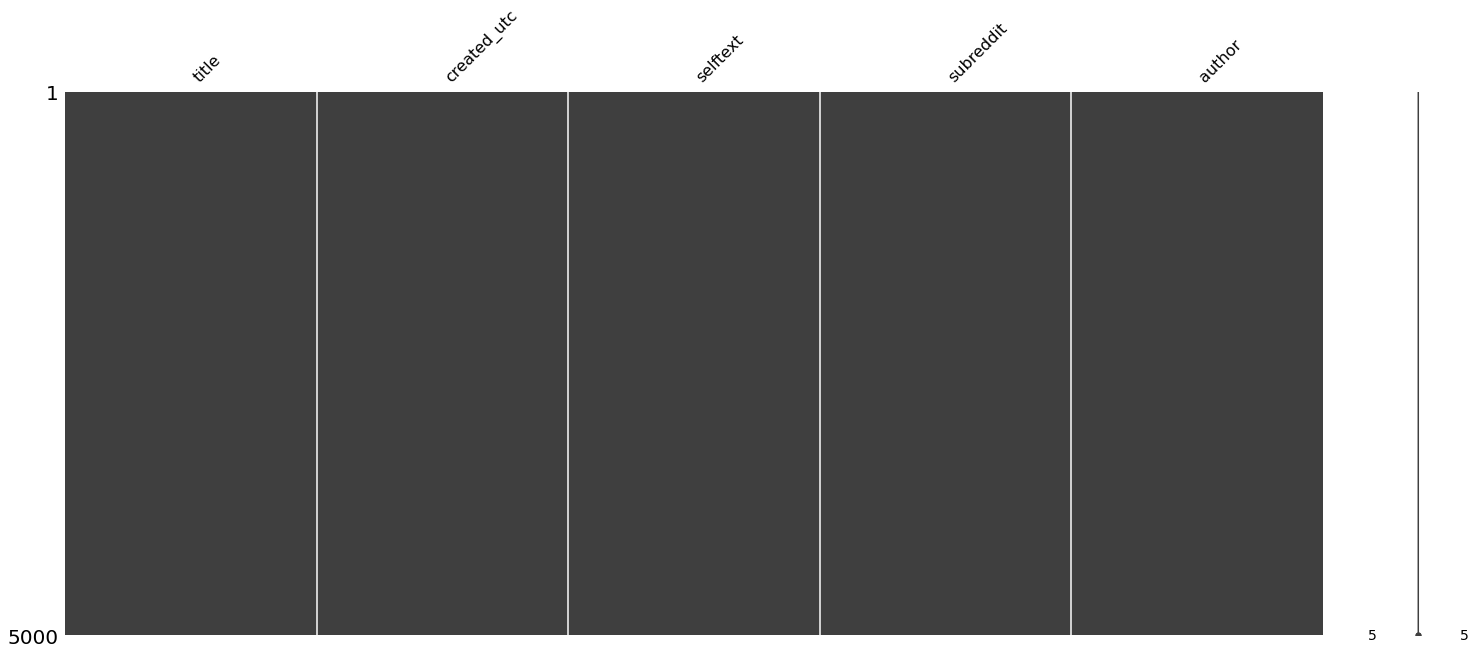

In [27]:
# Visualize NaNs
msno.matrix(anime_manga);

In [28]:
# Reset index due to earlier concatenation
anime_manga = anime_manga.reset_index()

In [29]:
# Rename selftext to post
anime_manga.rename(columns={'selftext': 'post'},inplace=True)

In [30]:
anime_manga.tail()

,index,title,created_utc,post,subreddit,author
4995,95,"I made this coloring and i wanted to share it,...",1600690559,,manga,Joe_Ikari
4996,96,I was bored and i gave color to this zero two ...,1600690462,[deleted],manga,[deleted]
4997,97,[DISC] Ramia - Hero &amp; Demon Lord Chronicle...,1600689756,,manga,TGSmurf
4998,98,A rookie mangaka named Takeshi Yumesaki made a...,1600689703,,manga,trover2345325
4999,99,[DISC] The Lady's Law of Survival CHAPTER 7,1600688636,,manga,Xixth


In [31]:
# Drop old index column
anime_manga = anime_manga.drop('index', axis = 1)

In [32]:
anime_manga.head()

,title,created_utc,post,subreddit,author
0,I wanna cry. This is my first proper anime jou...,1601390609,,anime,marsy_what_s_up
1,ios 14 anime theme ( ^ω^ ),1601390323,,anime,deluxeconan
2,Upcoming Fall 2020 Anime You Need to WATCH,1601390279,,anime,animenewsupdates
3,im kind of having an identity crisis rn plz help,1601389966,ok so i was thinking about how there are 3 pri...,anime,Aclover69
4,"Sauce for this character..? Please help, /Anime",1601389834,Who knows [this anime-style character](https:/...,anime,stuck_key


In [33]:
# Preview removed to see how it looks in dataset
anime_manga[anime_manga['post'] == '[removed]'].head(8)

,title,created_utc,post,subreddit,author
12,About Higurashi...,1601389275,[removed],anime,monkaydoodaa
13,Recommend Manga Please,1601389274,[removed],anime,Zeromuya_Yato
27,Anime is gay and gives you corona~Hayao Miyazaki,1601387868,[removed],anime,postingcringee
29,Unpopular opinion: Oregairu is kinda garbage,1601387708,[removed],anime,Txkagi
57,One Piece,1601385146,[removed],anime,sam_eone
59,is it important that i watch the noblese OVAs ...,1601384682,[removed],anime,Ahmed-333
86,Streaming plateforme,1601378133,[removed],anime,orcasifilus
93,anime recommend,1601376652,[removed],anime,anime-lover123


In [34]:
# Replace removed and deleted in dataset with empty string
anime_manga['post'] = anime_manga['post'].replace('[removed]', '')

In [35]:
anime_manga['post'] = anime_manga['post'].replace('[deleted]', '')

In [36]:
# Preview the point and surrounding data points where dataset goes from anime to manga subreddit
anime_manga.loc[2495:2505]

,title,created_utc,post,subreddit,author
2495,AOT S4,1601074228,,anime,xPrinceofSaiyans
2496,I just got into anime and was wondering where ...,1601074211,I just started watching anime but I don’t have...,anime,sanslikeslolis
2497,What was the episode of Shokugeki No Soma wher...,1601073766,I wanna find it so I can get a recipe for the ...,anime,DelusionalDonut13
2498,Zoro vs Killer Full Fight (English Subbed),1601073672,,anime,ESWAGGER8
2499,Any popular show with universal agreement abou...,1601073297,I was thinking about this due to a comment in ...,anime,Emi_Ibarazakiii
2500,Is there a Manga with a paraplegic as the main...,1601390572,I'm curious,manga,ComradKenobi
2501,Is there a manga with a paraplegic as a main c...,1601390521,I'm curious,manga,ComradKenobi
2502,Manga&gt;&gt;&gt;&gt;anime.,1601390414,,manga,AxelXIV
2503,[DISC] Shaman King: Marcos Vol. 1 Ch. 3 - Chan...,1601390163,,manga,SenorNoobnerd
2504,Manga Recommendations,1601389678,I like Comedy/School Life/Slice of life Manga....,manga,Zeromuya_Yato


In [37]:
# Creating label column to distinguish subreddits
anime_manga['label'] = 1

In [38]:
anime_manga.head()

,title,created_utc,post,subreddit,author,label
0,I wanna cry. This is my first proper anime jou...,1601390609,,anime,marsy_what_s_up,1
1,ios 14 anime theme ( ^ω^ ),1601390323,,anime,deluxeconan,1
2,Upcoming Fall 2020 Anime You Need to WATCH,1601390279,,anime,animenewsupdates,1
3,im kind of having an identity crisis rn plz help,1601389966,ok so i was thinking about how there are 3 pri...,anime,Aclover69,1
4,"Sauce for this character..? Please help, /Anime",1601389834,Who knows [this anime-style character](https:/...,anime,stuck_key,1


In [39]:
# Change label to 0 for anime subreddit
for i in range(0, 2500):
    anime_manga['label'][i] = 0

<ipython-input-39-48ccff26696c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_manga['label'][i] = 0


In [40]:
anime_manga.loc[2495:2505]

,title,created_utc,post,subreddit,author,label
2495,AOT S4,1601074228,,anime,xPrinceofSaiyans,0
2496,I just got into anime and was wondering where ...,1601074211,I just started watching anime but I don’t have...,anime,sanslikeslolis,0
2497,What was the episode of Shokugeki No Soma wher...,1601073766,I wanna find it so I can get a recipe for the ...,anime,DelusionalDonut13,0
2498,Zoro vs Killer Full Fight (English Subbed),1601073672,,anime,ESWAGGER8,0
2499,Any popular show with universal agreement abou...,1601073297,I was thinking about this due to a comment in ...,anime,Emi_Ibarazakiii,0
2500,Is there a Manga with a paraplegic as the main...,1601390572,I'm curious,manga,ComradKenobi,1
2501,Is there a manga with a paraplegic as a main c...,1601390521,I'm curious,manga,ComradKenobi,1
2502,Manga&gt;&gt;&gt;&gt;anime.,1601390414,,manga,AxelXIV,1
2503,[DISC] Shaman King: Marcos Vol. 1 Ch. 3 - Chan...,1601390163,,manga,SenorNoobnerd,1
2504,Manga Recommendations,1601389678,I like Comedy/School Life/Slice of life Manga....,manga,Zeromuya_Yato,1


## EDA and Preprocessing

In [43]:
# source: https://gist.github.com/MrEliptik/b3f16179aa2f530781ef8ca9a16499af
# convenient functions to call upon for manual preprocessing

def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", sample)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

def preprocess(sample):
    sample = remove_URL(sample)
    
    # Tokenize
    words = nltk.word_tokenize(sample)

    # Normalize
    return normalize(words)

In [44]:
# Mapping preprocessing functions to title and post columns
anime_manga['title'] = anime_manga['title'].map(preprocess)
anime_manga['post'] = anime_manga['post'].map(preprocess)

In [72]:
# Lemmatizing verbs for title and post columns
anime_manga['title'] = anime_manga['title'].map(lemmatize_verbs)
anime_manga['post'] = anime_manga['post'].map(lemmatize_verbs)

In [73]:
anime_manga.head()

,title,created_utc,post,subreddit,author,label
0,"[wan, na, cry, first, proper, anime, journal, ...",1601390609,[],anime,marsy_what_s_up,0
1,"[ios, 14, anime, theme]",1601390323,[],anime,deluxeconan,0
2,"[upcoming, fall, 2020, anime, need, watch]",1601390279,[],anime,animenewsupdates,0
3,"[im, kind, identity, crisis, rn, plz, help]",1601389966,"[ok, think, 3, primary, class, anime, watchers...",anime,Aclover69,0
4,"[sauce, character, please, help, anime]",1601389834,"[know, animestyle, character, find, old, game,...",anime,stuck_key,0


In [86]:
# Putting manually tokenized title and post lists back into string form
for i in range(len(df_copy)):
    anime_manga['title'][i] = ' '.join(anime_manga['title'][i])
    anime_manga['post'][i] = ' '.join(anime_manga['post'][i])

<ipython-input-86-4deba57de26a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_manga['title'][i] = ' '.join(anime_manga['title'][i])
<ipython-input-86-4deba57de26a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_manga['post'][i] = ' '.join(anime_manga['post'][i])


In [87]:
anime_manga.head()

,title,created_utc,post,subreddit,author,label
0,wan na cry first proper anime journal happy ca...,1601390609,,anime,marsy_what_s_up,0
1,ios 14 anime theme,1601390323,,anime,deluxeconan,0
2,upcoming fall 2020 anime need watch,1601390279,,anime,animenewsupdates,0
3,im kind identity crisis rn plz help,1601389966,ok think 3 primary class anime watchers wonder...,anime,Aclover69,0
4,sauce character please help anime,1601389834,know animestyle character find old game magazi...,anime,stuck_key,0


In [88]:
anime_manga.to_csv('anime_manga.csv')

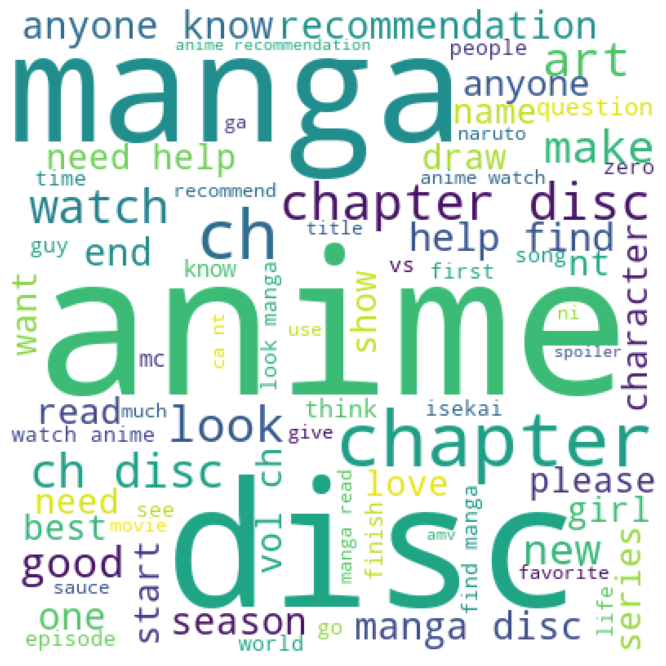

In [228]:
# source: https://www.datacamp.com/community/tutorials/wordcloud-python

# Create new dataframe for wordcloud
wc_df = pd.read_csv('./data/anime_manga.csv') 

# Establish text variable and set stopwords (imported)
text = ' '
stopwords = set(STOPWORDS) 
  
# Iterating through dataframe to split words and add words to wordcloud
for i in wc_df.title:  
    i = str(i)  
    values = i.split()     
    for words in values: 
        text = text + words + ' ' # setting up for wordcloud
        
# Declaring wordcloud  
wc = WordCloud(max_words= 75, width = 400, height = 400, background_color ='white', stopwords=stopwords, contour_width=2.5, contour_color='purple', min_font_size = 8).generate(text) 
  
# Plotting wordcloud                        
plt.figure(figsize = (12, 12)) 
plt.imshow(wc) 
plt.axis("off");

In [175]:
X_train_cv.head(10)

,000,00s,02,09272020,0nin,10,100,1000,1000000,100gf,...,zerotwo,zetsubou,zetton,zoldyck,zombie,zone,zooted,zoro,zu,zutto
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
top_words = {}

# loop through columns
for i in X_train_cv.columns:
    # save sum of each column in dictionary
    top_words[i] =  X_train_cv[i].sum()

In [171]:
most_freq = pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True))

In [172]:
most_freq_df = pd.DataFrame(most_freq)

In [173]:
most_freq_df.head()

,0,1
0,anime,616
1,disc,614
2,manga,495
3,chapter,308
4,ch,273


<Figure size 720x360 with 0 Axes>

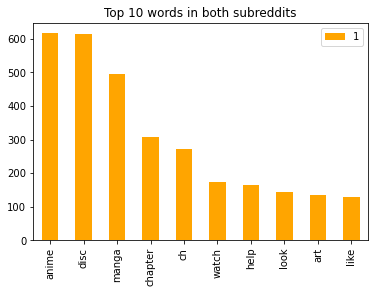

In [181]:
plt.figure(figsize = (10, 5))

# visualize top 10 words

most_freq_df.nlargest(10, 1).plot(kind = 'bar', color = 'orange', title = 'Top 10 words in both subreddits')
plt.xticks([i for i in range(10)], [col for col in most_freq_df.nlargest(10, 1)[0]]);

## Modeling

In [225]:
# Declaring X and y for modeling
X = anime_manga[['title']]
y = anime_manga['label']

In [208]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42, stratify = y)

In [223]:
# Show shapes of sets to double check
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3350, 1)
(1650, 1)
(3350,)
(1650,)


In [92]:
# Baseline accuracy
1 - y_train.sum()/len(y_train)

0.5

In [93]:
# Set up CountVectorizer, strip accents due to large range of characters used in each subreddit
cv = CountVectorizer(stop_words='english', strip_accents = 'ascii')

# Transform on title
cv.fit_transform(X_train['title'])

<3350x4514 sparse matrix of type '<class 'numpy.int64'>'
	with 16703 stored elements in Compressed Sparse Row format>

In [94]:
# Use toarray and get_feature_names while making new DataFrame as a nice way to grab & evaluate all word occurrences
X_train_cv = pd.DataFrame(cv.transform(X_train['title']).toarray(), columns = cv.get_feature_names())
X_test_cv = pd.DataFrame(cv.transform(X_test['title']).toarray(), columns = cv.get_feature_names())

In [95]:
# Basic Logistic Regression
lr = LogisticRegression()

In [96]:
# Fitting Regression
lr.fit(X_train_cv, y_train)

LogisticRegression()

In [98]:
# Displaying score for test set
lr.score(X_test_cv, y_test)

0.8866666666666667

In [99]:
# Basic Naive Bayes model, using 0.02 alpha and False on fit_prior to maximize accuracy
nb = MultinomialNB(alpha = 0.02, fit_prior = False)

In [227]:
# Fitting model
nb.fit(X_train_cv, y_train)

MultinomialNB(alpha=0.02, fit_prior=False)

In [102]:
# Test score
nb.score(X_test_cv, y_test)

0.8587878787878788

### Evaluation of Models and Moving Forward

To my surprise, the LogisticRegression model was more accurate than the MultinomialNB model. I was surprised because the Naive Bayes model seemed to suit the classification the most on paper, basing its fundamentals on probabilities of training data variables (words within subreddits). However, I think what attributed to the Logistic Regression model's slightly higher accuracy is the focus on the label variables within the train_test_split. In addition, I found that the Naive Bayes model had not as consistent results with multiple tests, with a great range in accuracies. The accuracy overall was surprisingly high for basic model evaluation. A score greater than 85% suggests that the model is highly accurate when predicting subreddit. The score may not have been nearly as high if not predicted from the title of the post, as the titles are likely much more distinct than the contents of the posts themselves.

I think moving forward with this project, I could do far more exploration with models and even adjusting the X and y variables, focusing on post within the X and maybe exploring other columns like score. Using more models, like Random Forest and Decision Trees, is definitely something I would like to implement. In addition, increasing the accuracy of the models with GridSearchCV and pipelines is something I wanted to do. Finally, displaying a confusion matrix after implementing a GridSearch would be great to visualize the predicted labels.

## Conclusions and Recommendations

Logistic Regression is the most accurate model tested, sporting roughly an **89%** accuracy. While not included in this notebook, testing the same type of model multiple times led to differing accuracies, so creating multiple models with slight tweaks could be used to maximize accuracy. CountVectorizer automates a large portion of the manual cleaning I did without reducing accuracy. I'd recommend adding more features to the API and to models to strengthen accuracy as well as potential for modeling.

Outside sources: 
https://gist.github.com/MrEliptik/b3f16179aa2f530781ef8ca9a16499af
https://www.datacamp.com/community/tutorials/wordcloud-python
https://www.reddit.com/r/anime
https://www.reddit.com/r/manga